In [21]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [22]:
from package.helpers import test_physical_lens
from package.plots import diagnostic_plot, plot

In [23]:
figure_dir = os.path.join(repo_path, 'figures', 'diagnostics', 'pixel_density_test')
array_dir = os.path.join(repo_path, 'output', 'arrays', 'diagnostics', 'pixel_density_test')

# Generate images with various PSFs

In [24]:
physical_lens = test_physical_lens.TestPhysicalLens()

num_pix = 45
band = 'f106'

## No PSF

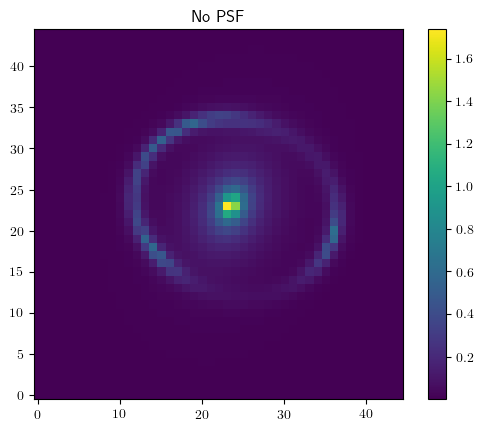

(45, 45)


In [25]:
kwargs_psf_none = {'psf_type': 'NONE'}

no_psf = physical_lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_none)

plot.plot(filepath=None,
          title='No PSF',
          array=no_psf,
          colorbar=True)

print(no_psf.shape)

## Gaussian PSF

I'm getting the PSF FWHM values from [here](https://roman.gsfc.nasa.gov/science/WFI_technical.html). From that webpage: "Note: PSF FWHM in arcseconds simulated at the center of the center pixel of a detector near the center of the WFI FOV using an input spectrum for a K0V type star."

In [26]:
psf_fwhm = {
    'f062': 0.058,
    'f087': 0.073,
    'f106': 0.087,
    'f129': 0.105,
    'f158': 0.127,
    'f184': 0.151,
    'f213': 0.175,
    'f146': 0.105
}

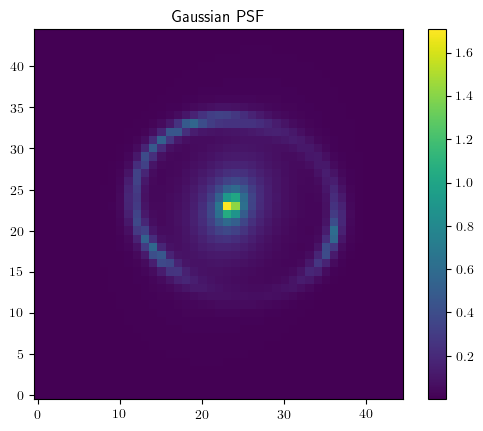

(45, 45)


In [35]:
kwargs_psf_gaussian = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm.get(band)}

gaussian_psf = physical_lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_gaussian)

plot.plot(filepath=None,
          title='Gaussian PSF',
          array=gaussian_psf,
          colorbar=True)

print(gaussian_psf.shape)

## `lenstronomy` Roman module, which uses a pixel PSF

Not sure where they got the PSFs and under what conditions they were generated, but they're `.fits` files

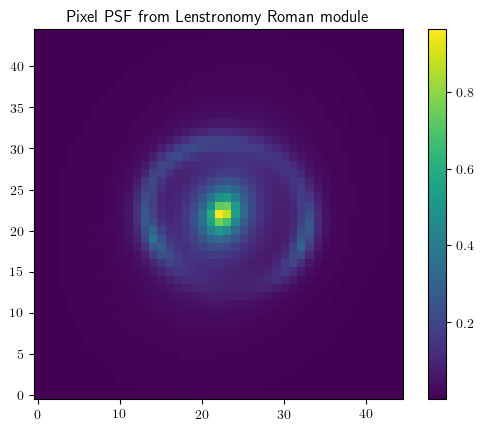

(45, 45)


In [36]:
pixel_psf, _, _ = physical_lens.get_roman_sim(noise=False)

plot.plot(filepath=None,
          title='Pixel PSF from Lenstronomy Roman module',
          array=pixel_psf,
          colorbar=True)

print(pixel_psf.shape)

# Compare

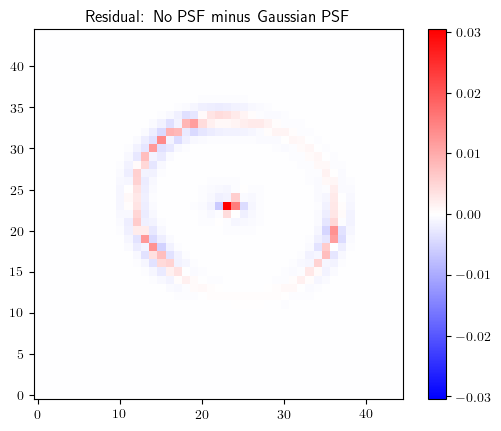

In [37]:
diagnostic_plot.residual(None, 'Residual: No PSF minus Gaussian PSF', no_psf, gaussian_psf)

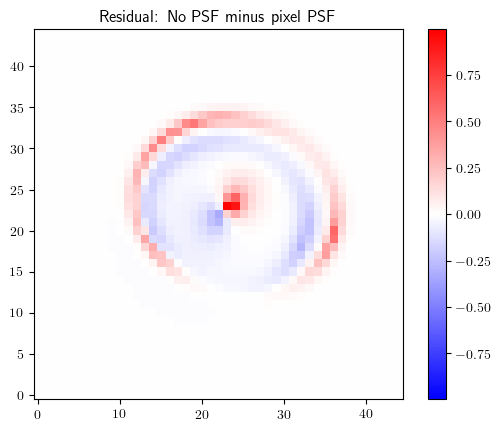

In [38]:
diagnostic_plot.residual(None, 'Residual: No PSF minus pixel PSF', no_psf, pixel_psf)